<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/bank_marketing_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank markerting classification with decision trees

**Goal:**

The main goal is to develop a predictive model which will tell if a client is open to create a term deposit based on the client's characteristics

**Hypothesis:**

The base hypothesis is that the wealthier, middle-aged people are the most potential customers in regards of the deposit.

**Data Set Information:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [1]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip 
! unzip /content/bank.zip

--2020-09-26 11:39:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579043 (565K) [application/x-httpd-php]
Saving to: ‘bank.zip.3’

bank.zip.3          100%[===================>] 565.47K  1.71MB/s    in 0.3s    

2020-09-26 11:39:30 (1.71 MB/s) - ‘bank.zip.3’ saved [579043/579043]

Archive:  /content/bank.zip
replace bank-full.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [2]:
import pandas as pd

# Use the smaller dataset for now
# df = pd.read_csv('/content/bank.csv', sep=';')

In [3]:
df_full = pd.read_csv('/content/bank-full.csv', sep=';')

In [4]:
print(df_full.shape)

(45211, 17)


In [138]:
# Reserve samples for final evaluation
test_df = df_full[:8000]
validation_df = df_full[8000:16000]
df = df_full = df_full[16000:]

## Exploratory analysis

In [139]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
32000,29,services,divorced,secondary,no,84,yes,no,cellular,13,apr,1101,2,-1,0,unknown,yes
32001,31,management,single,tertiary,no,999,yes,no,cellular,13,apr,187,5,-1,0,unknown,no
32002,52,blue-collar,married,secondary,no,543,yes,no,cellular,13,apr,211,2,-1,0,unknown,no
32003,36,admin.,single,secondary,no,587,yes,no,cellular,13,apr,239,3,-1,0,unknown,no
32004,27,services,single,secondary,no,150,no,no,cellular,13,apr,81,3,-1,0,unknown,no


In [140]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 32000 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        13211 non-null  int64 
 1   job        13211 non-null  object
 2   marital    13211 non-null  object
 3   education  13211 non-null  object
 4   default    13211 non-null  object
 5   balance    13211 non-null  int64 
 6   housing    13211 non-null  object
 7   loan       13211 non-null  object
 8   contact    13211 non-null  object
 9   day        13211 non-null  int64 
 10  month      13211 non-null  object
 11  duration   13211 non-null  int64 
 12  campaign   13211 non-null  int64 
 13  pdays      13211 non-null  int64 
 14  previous   13211 non-null  int64 
 15  poutcome   13211 non-null  object
 16  y          13211 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.7+ MB


### Numerical features

In [141]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000,13211.000000
mean,40.548861,1519.160170,14.099841,270.099841,2.071304,109.084551,1.455908
std,12.750322,3242.508932,7.384843,244.125282,1.603668,146.279477,2.793161
min,18.000000,-4057.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,31.000000,144.000000,8.000000,115.000000,1.000000,-1.000000,0.000000
50%,37.000000,558.000000,14.000000,202.000000,2.000000,-1.000000,0.000000
75%,48.000000,1667.500000,18.000000,342.000000,2.000000,188.000000,2.000000
max,95.000000,102127.000000,31.000000,3785.000000,23.000000,871.000000,58.000000


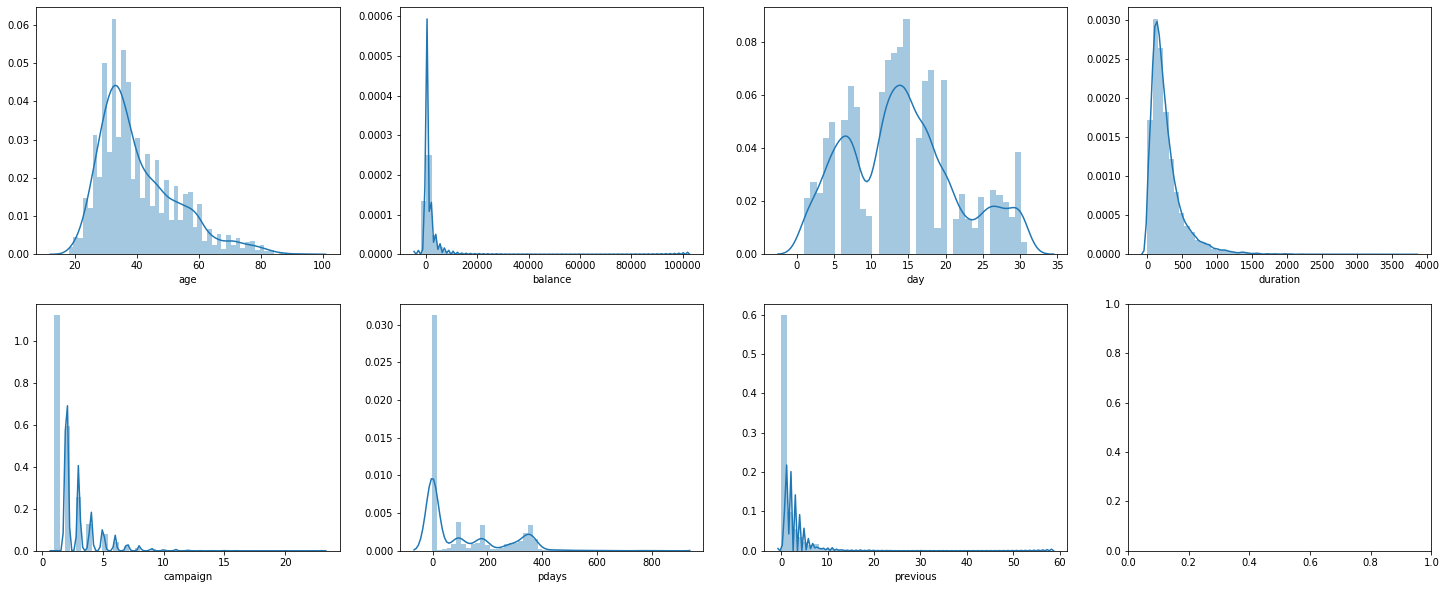

In [142]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numericals(data, features):
  fig, axes = plt.subplots(2,4, figsize=(25,10))
  for ax, f in zip(axes.ravel(), features):
    sns.distplot(data[f], ax=ax)

numericals = df.select_dtypes([np.number]).columns
plot_numericals(df, numericals)

#### Age
Main focus has been on people with age between 30 and 40. Young people might not have that much extra cash and old people might not want to take term deposit, at least not for years forward.

#### Account balance (eur)
Most of the people have balance between 0 and 10 000 euros, although it goes from -30000 up to 70 000.

#### Last contact day of the month
Does not tell much, this is column should be analyzed with month feature which at this point is in categorical format (string values).
Days with less contacts might fall in weekends.

#### Phone call duration
On average calls took 4-5 minutes. There's much longer calls though. The longest reported call has taken 3000 seconds ( = 50 minutes).
Maybe there's correlation with phone duration and term deposits since bank needs to ask all kind of information for term deposit. Of course this depends on the bank's own practices.

#### Contacts during the campaign
Mostly only a few contacts per customer, the data does not tell us if all the contacts are about term deposit. It's hard to imagine situation where bank contacts over 10 times the same client about the same term deposit unless there's lots of confusion between these parties.

#### Number of days passed after the last contact of the previous campaign
Most of the clients were not part of the last campaign thus the peak at the start.

#### Number of contacts before this campaign
No previous or only a few were conducted for the most of the clients.

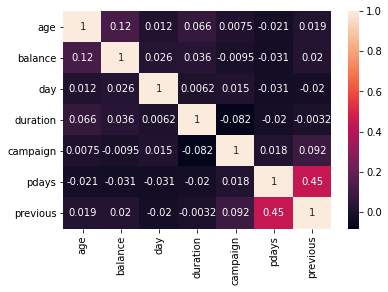

In [143]:
corr = df.corr()
sns.heatmap(corr, annot=True)

No strong correlations with numerical features except pdays and previous.

### Categorical features

In [144]:
categoricals = df.select_dtypes(['object'])
categoricals.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
32000,services,divorced,secondary,no,yes,no,cellular,apr,unknown,yes
32001,management,single,tertiary,no,yes,no,cellular,apr,unknown,no
32002,blue-collar,married,secondary,no,yes,no,cellular,apr,unknown,no
32003,admin.,single,secondary,no,yes,no,cellular,apr,unknown,no
32004,services,single,secondary,no,no,no,cellular,apr,unknown,no


In [145]:
def plot_categorical_count(ax, data, feature):
  plot = sns.countplot(data=data, x=feature, ax=ax)

  plot.set_xticklabels(
    plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
  )

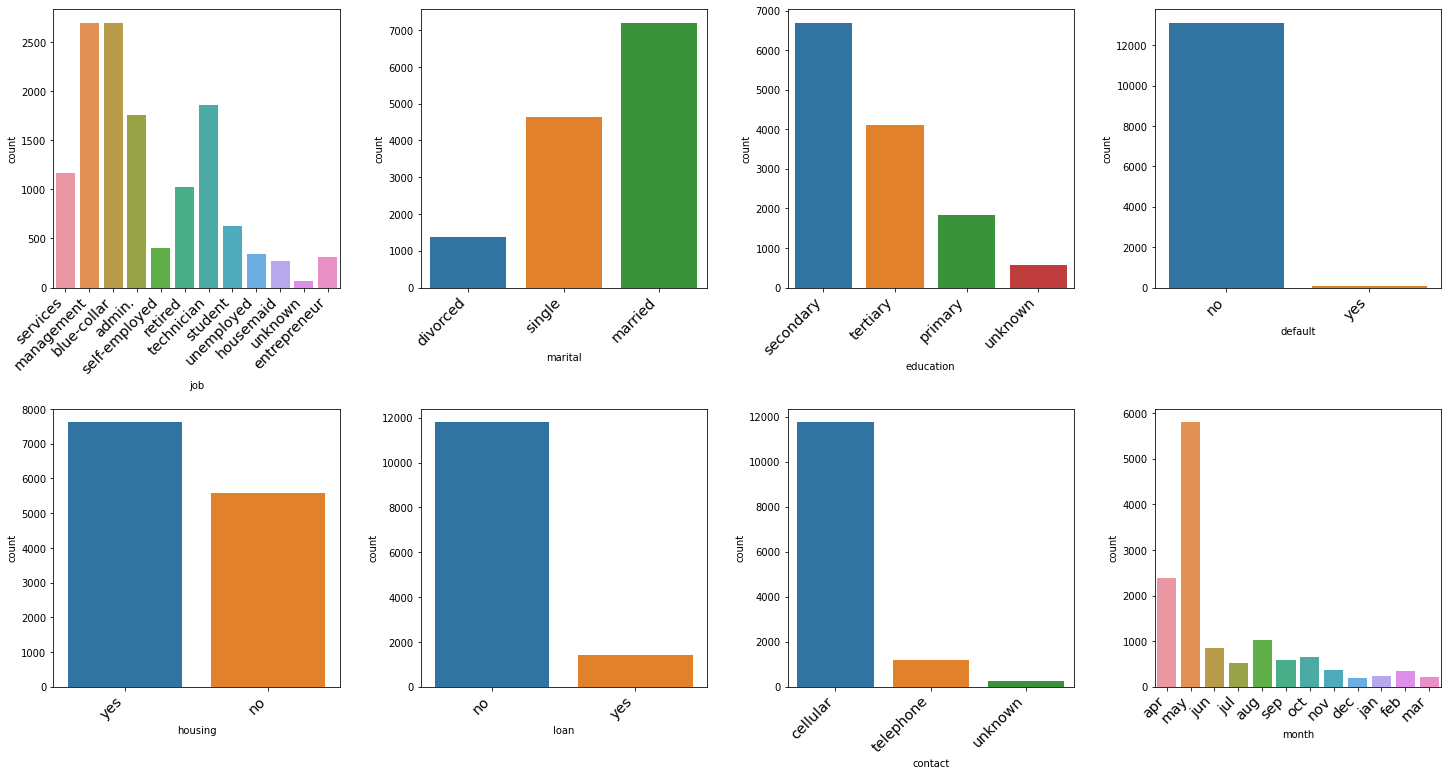

In [146]:
count = len(categoricals.columns)
fig, axes = plt.subplots(int(count / 4), 4, figsize=(20,10))
fig.tight_layout(w_pad=5.0, h_pad=10.0)

for ax, c in zip(axes.ravel(), categoricals):
  plot_categorical_count(ax, df, c)


- The campaign seems to focus on people with medium income, higher degree and without previous loans or defaults
- Interestingly enough, majority of the clients have no loan but own a house which means that the focus is on the wealthy people

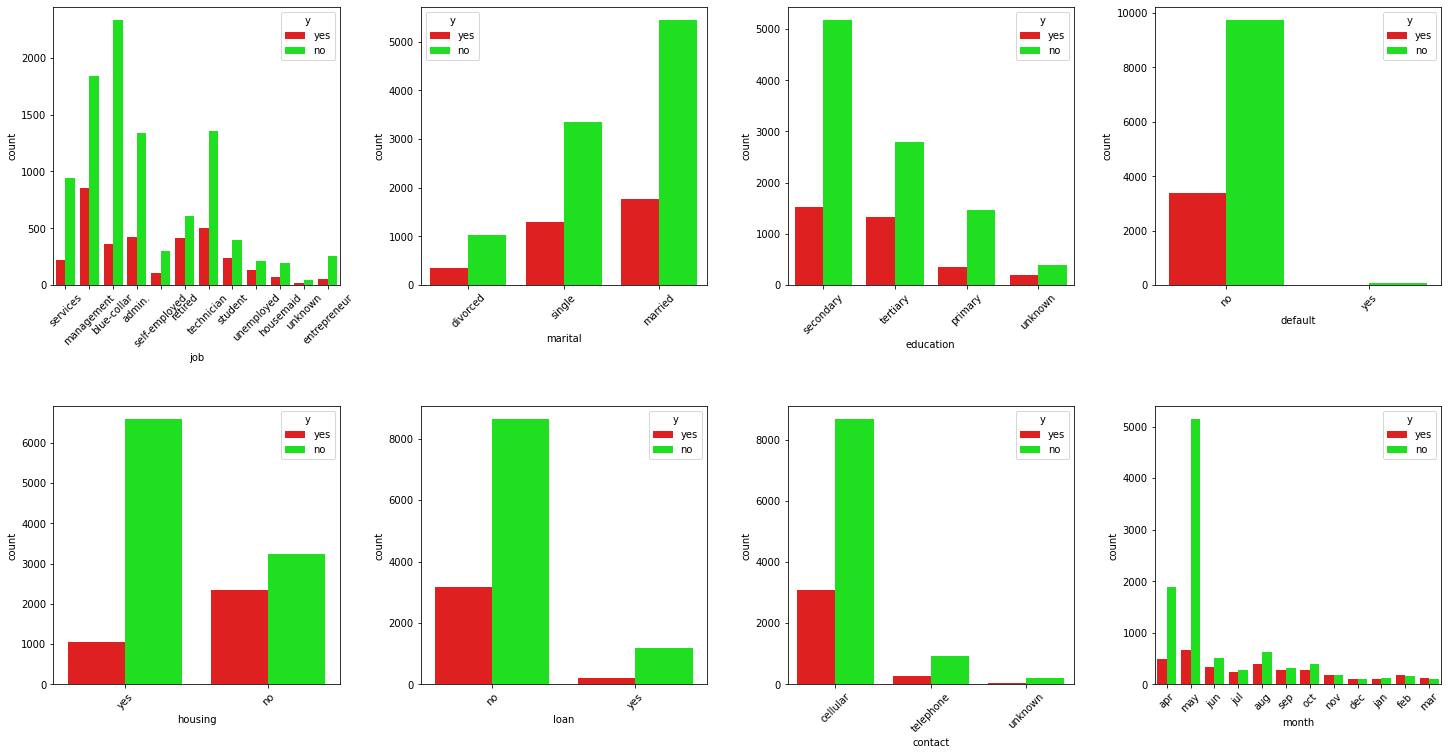

In [147]:
def plot_label_count(ax, data, feature):
  ax.tick_params(axis='x', labelrotation=45)
  sns.countplot(x=feature, hue='y', data=data, ax=ax, palette=['#FF0000',"#00FF00"])

count = len(categoricals.columns)
fig, axes = plt.subplots(int(count / 4), 4, figsize=(20,10))
fig.tight_layout(w_pad=5.0, h_pad=10.0)

for ax, c in zip(axes.ravel(), categoricals):
  plot_label_count(ax, df, c)

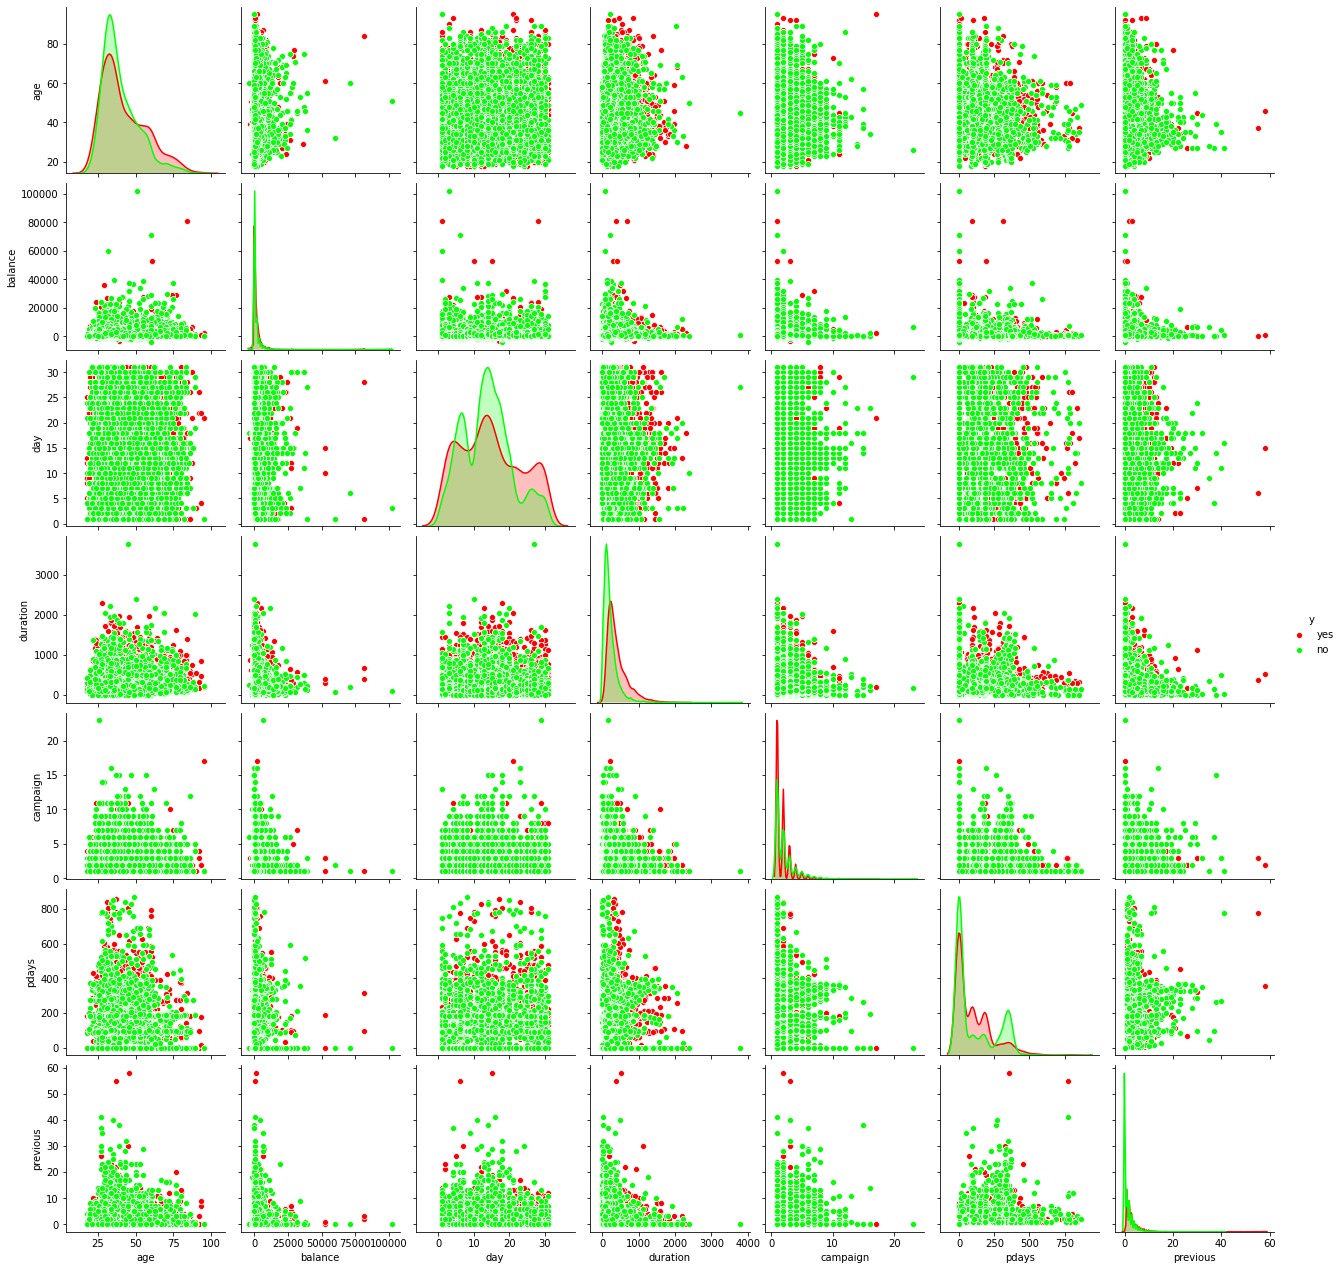

In [148]:
sns.pairplot(df, hue='y', palette=['#FF0000',"#00FF00"])

- Short calls tend to end up rejection
- The shorter the call and the more balance a client has, there's tendency reject the offer

In [149]:
from sklearn.preprocessing import LabelEncoder
# Convert label to numerical form
numlabel = df.copy()

le = LabelEncoder()
x = le.fit_transform(numlabel['y'])

numlabel['y'] = x

# Same as a one-liner
# numlabel['y'] = np.where(df['y'] == 'yes', 1, 0)

numlabel.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
32000,29,services,divorced,secondary,no,84,yes,no,cellular,13,apr,1101,2,-1,0,unknown,1
32001,31,management,single,tertiary,no,999,yes,no,cellular,13,apr,187,5,-1,0,unknown,0
32002,52,blue-collar,married,secondary,no,543,yes,no,cellular,13,apr,211,2,-1,0,unknown,0
32003,36,admin.,single,secondary,no,587,yes,no,cellular,13,apr,239,3,-1,0,unknown,0
32004,27,services,single,secondary,no,150,no,no,cellular,13,apr,81,3,-1,0,unknown,0


In [150]:
label_corr = numlabel.corr()
label_corr['y'].sort_values(ascending=False)

y           1.000000
duration    0.356601
age         0.084344
balance     0.071343
day         0.062110
previous    0.056456
pdays      -0.028475
campaign   -0.089777
Name: y, dtype: float64

### Data preparation and cleaning

- No missing data so we don't have to impute any values


#### Outliers

[0]
[0]
[0]


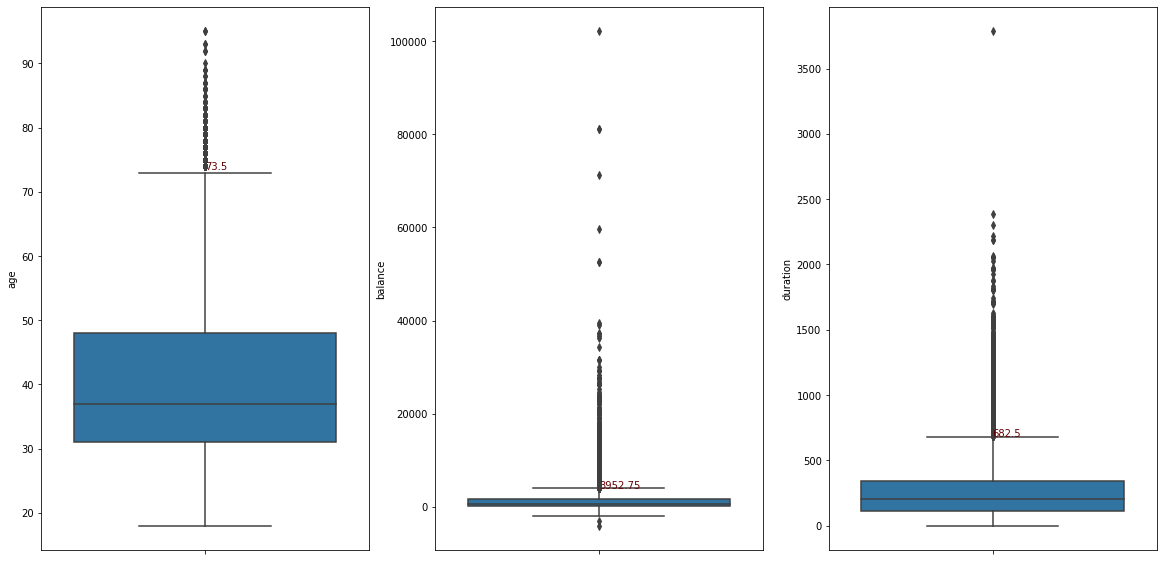

In [151]:

def calculate_outlier_bound(data):
  q1, q3 = np.percentile(data,[25,75])
  iqr = q3 - q1
  upper_bound = q3 +(1.5 * iqr) 
  return upper_bound

fig, axes = plt.subplots(1,3, figsize=(20,10))
features = ['age', 'balance', 'duration']
for ax, f in zip(axes, features):
  boxplot = sns.boxplot(y=f, data=numlabel, ax=ax)
  print(boxplot.get_xticks())
  upper_bound = calculate_outlier_bound(df[f])
  boxplot.text(x=0, y=upper_bound, s=str(upper_bound), color='#660000')

In [152]:
def remove_outliers(data, features):
  tmp = data.copy()
  for f in features:
    upper_limit = calculate_outlier_bound(data[f])
    outlier_idxs = tmp[tmp[f] > upper_limit].index
    tmp.drop(outlier_idxs, axis=0, inplace=True)
  return tmp

#clean = remove_outliers(df, features)

In [153]:
# Group durations to closest full minute
clean['duration'] = np.round(clean['duration'] / 60).astype('uint8')

### Building a pipeline for the data transformation

In [154]:
features = clean.drop('y', axis=1)
labels = clean['y']

clean[categoricals.columns].head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
16000,entrepreneur,married,secondary,no,yes,yes,cellular,jul,unknown,no
16001,self-employed,single,secondary,no,no,no,cellular,jul,unknown,no
16002,student,single,tertiary,no,yes,no,cellular,jul,unknown,no
16003,admin.,married,secondary,no,no,no,cellular,jul,unknown,no
16004,entrepreneur,married,secondary,no,yes,no,cellular,jul,unknown,no


In [166]:
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [168]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# With decision trees, it's not really necessary to scale features
# but let's do it for the sake of practice
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(TargetEncoder())

# Sklearn knows nothing about Pandas DataFrame, it accepts only numpy arrays
num_attribs = list(numericals)
cat_attribs = list(categoricals.drop('y', axis=1).columns)

# FeatureUnion applies different transformers to the WHOLE of the input data
# ColumnTransformer applies different transformers to different SUBSETS of the whole input data
full_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, num_attribs),
        ("categorical", cat_pipeline, cat_attribs)
    ])

le = LabelEncoder()
prepared_labels = le.fit_transform(labels)

# Runs both num and cat pipelines in parallel
prepared_features = full_pipeline.fit_transform(features, prepared_labels)



In [169]:
pd.DataFrame(prepared_features).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.004072,-1.161865,0.662238,0.0,-0.578565,-0.54041,-0.310078,0.069829,0.104517,0.109403,0.121791,0.067904,0.050894,0.12144,0.077739,0.089132
1,-1.004072,-0.584149,0.662238,0.0,-0.578565,-0.54041,-0.310078,0.113636,0.155499,0.109403,0.121791,0.171617,0.132672,0.12144,0.077739,0.089132
2,-1.100388,-0.090192,0.662238,0.0,-0.578565,-0.54041,-0.310078,0.305677,0.155499,0.150605,0.121791,0.067904,0.132672,0.12144,0.077739,0.089132
3,-0.329861,-0.660391,0.662238,0.0,1.044560,-0.54041,-0.310078,0.138889,0.104517,0.109403,0.121791,0.171617,0.132672,0.12144,0.077739,0.089132
4,1.211192,-0.790323,0.662238,0.0,-0.578565,-0.54041,-0.310078,0.069829,0.104517,0.109403,0.121791,0.067904,0.132672,0.12144,0.077739,0.089132


### Training a model

In [170]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(prepared_features, prepared_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [171]:
def plot_precision_recall_curve(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.1])
  plt.xlim([0.0, 1.0])

In [172]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, plot_roc_curve, precision_recall_curve, plot_confusion_matrix

def report_results(clf, X, y, preds):
  print('Number of non-subscribed:', len(y[y == 0]))
  print('Number of subscribed:', len(y[y == 1]))
  
  clf_report = classification_report(y, preds)
  print(clf_report)

  plot_precision_recall_curve(y, preds)
  plot_confusion_matrix(clf, X, y)
  plot_roc_curve(clf, X, y)
  auc = roc_auc_score(y, clf.predict_proba(X)[:,1])
  print('AUC score: {}'.format(auc))

In [173]:
predictions = dtc.predict(prepared_features)

Number of non-subscribed: 21297
Number of subscribed: 2915
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21297
           1       1.00      1.00      1.00      2915

    accuracy                           1.00     24212
   macro avg       1.00      1.00      1.00     24212
weighted avg       1.00      1.00      1.00     24212

AUC score: 1.0


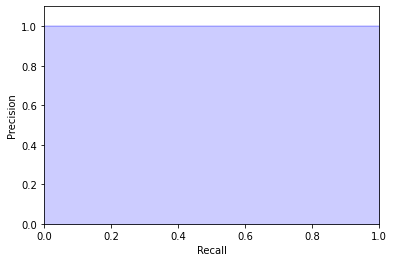

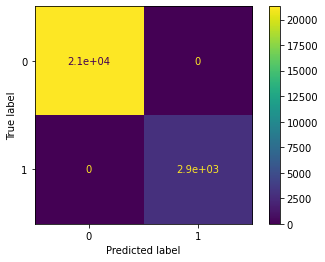

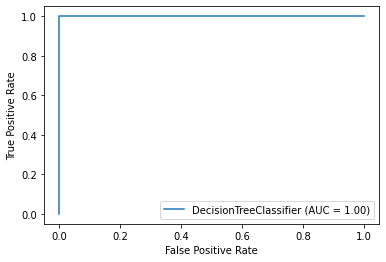

In [174]:
report_results(dtc, prepared_features, prepared_labels, predictions)

Seems like the model overfit the data hard.
Let's try with unseen data since we have another, full dataset

#### Handling overfitting

Techniques:
- Regularization
- More meaningful (latent) features, getting rid of the higher degree features
- More data

Number of non-subscribed: 7235
Number of subscribed: 765
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7235
           1       0.84      0.61      0.71       765

    accuracy                           0.95      8000
   macro avg       0.90      0.80      0.84      8000
weighted avg       0.95      0.95      0.95      8000

AUC score: 0.7978400205970433


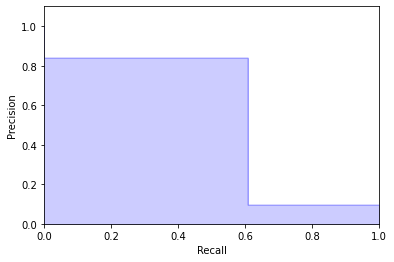

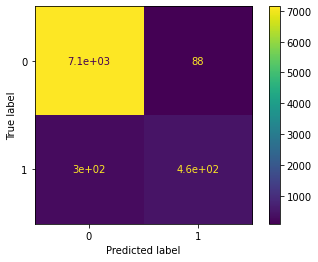

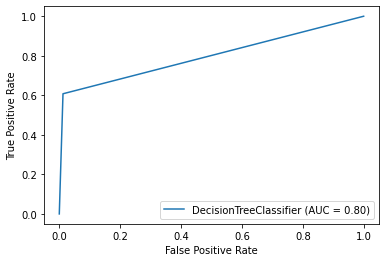

In [175]:
# Use unseen validation set
prepared_validation_features = full_pipeline.transform(validation_df.drop('y', axis=1))
prepared_validation_labels = le.transform(validation_df['y'])
predictions = dtc.predict(prepared_validation_features)

report_results(dtc, prepared_validation_features, prepared_validation_labels, predictions)

In [176]:
# Create more balanced dataset for training
df_full['y'].value_counts()

no     9818
yes    3393
Name: y, dtype: int64

In [177]:
no = df_full[df_full['y'] == 'no'][:4000]
yes = df_full[df_full['y'] == 'yes'][:4000]

balanced_df = pd.concat([no, yes])

# Shuffle dataset so model won't pick up any correlations from the order
balanced_df = balanced_df.sample(frac=1)

Number of non-subscribed: 7235
Number of subscribed: 765
              precision    recall  f1-score   support

           0       0.96      0.23      0.38      7235
           1       0.11      0.90      0.20       765

    accuracy                           0.30      8000
   macro avg       0.53      0.57      0.29      8000
weighted avg       0.87      0.30      0.36      8000

AUC score: 0.5532251085184132


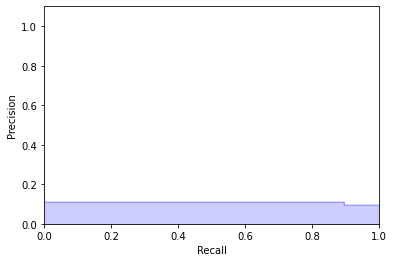

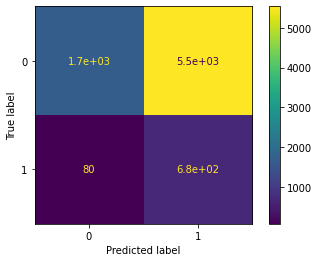

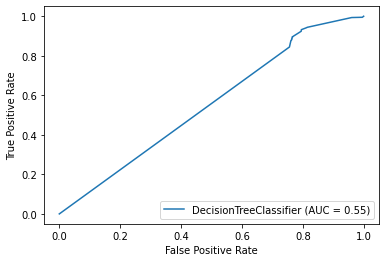

In [178]:
balanced_features = balanced_df.drop('y', axis=1)
features = full_pipeline.transform(balanced_features)
labels = le.transform(balanced_df['y'])

dtc2 = DecisionTreeClassifier(max_depth=8)
dtc2.fit(features, labels)

predictions = dtc2.predict(prepared_validation_features)
report_results(dtc2, prepared_validation_features, prepared_validation_labels, predictions)

In [179]:
for name, importance in zip(balanced_features.columns, dtc2.feature_importances_):
    print(name, importance)

age 0.00554638771804223
job 0.008255987668107865
marital 0.08170292527851845
education 0.18524015249970704
default 0.0010408886966012914
balance 0.014683236470326039
housing 0.0
loan 0.003986403155994232
contact 0.002420425973755814
day 0.0005806317899408564
month 0.0020148356236350477
duration 0.40610877113386945
campaign 0.0005620515726627493
pdays 0.004577392852087795
previous 0.23031101644928567
poutcome 0.05296889311746547


In [180]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=42)

grid_params = [{
    'max_depth': [1, 3, 5, 10, 20, 30],
    'min_samples_leaf': [1, 10, 50, 100]
}]

dtc3 = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc3, grid_params, cv=cv,
                           scoring='recall',
                           return_train_score=True)

grid_search.fit(features, labels)

print('Best params', grid_search.best_params_)
print('Best estimator', grid_search.best_estimator_)
print('Mean test score', grid_search.cv_results_['mean_test_score'])
print('Test score deviation', grid_search.cv_results_['std_test_score'])

Best params {'max_depth': 30, 'min_samples_leaf': 1}
Best estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Mean test score [0.69111221 0.69111221 0.69111221 0.69111221 0.84526003 0.84526003
 0.8343547  0.83022882 0.84585696 0.8449733  0.84408357 0.82404412
 0.88564391 0.87090507 0.85911956 0.81490045 0.90037579 0.88416637
 0.86265417 0.81490045 0.90067034 0.88446049 0.86265417 0.81490045]
Test score deviation [0.02710079 0.02710079 0.02710079 0.02710079 0.02124458 0.02124458
 0.0178433  0.02031869 0.02211436 0.02245716 0.02601995 0.03135426
 0.00776342 0.01803294 0.01433362 0.03196342 0.01201906 0.01282674


Number of non-subscribed: 7235
Number of subscribed: 765
              precision    recall  f1-score   support

           0       0.95      0.06      0.12      7235
           1       0.10      0.97      0.18       765

    accuracy                           0.15      8000
   macro avg       0.52      0.52      0.15      8000
weighted avg       0.87      0.15      0.12      8000

AUC score: 0.515136116644308


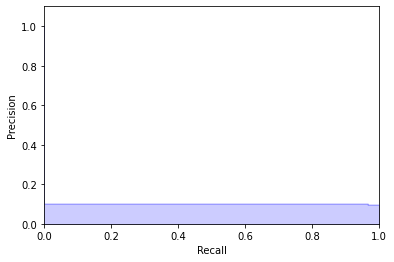

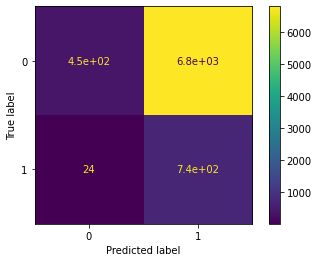

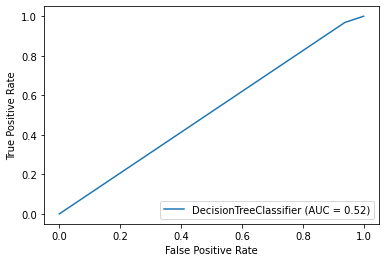

In [181]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(prepared_validation_features)
report_results(best_model, prepared_validation_features, prepared_validation_labels, predictions)


### Testing ensemble method (RandomForestClassifier)

In [182]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, oob_score=True)

grid_params_rf = [{
                'criterion': ['entropy'],
                'min_samples_leaf': [80, 100],
                'max_depth': [25, 27],
                'min_samples_split': [3, 5],
                'n_estimators' : [60, 70]
              }]

gridsearch_rf = GridSearchCV(rf, param_grid=grid_params_rf, scoring='accuracy', cv=cv)

In [183]:
gridsearch_rf.fit(features, labels)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min...eaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=Tru

In [184]:
print('Best params', gridsearch_rf.best_params_)
print('Best estimator', gridsearch_rf.best_estimator_)
print('Mean test score', gridsearch_rf.cv_results_['mean_test_score'])
print('Test score deviation', gridsearch_rf.cv_results_['std_test_score'])

Best params {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 80, 'min_samples_split': 3, 'n_estimators': 60}
Best estimator RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=80, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
Mean test score [0.88475271 0.88461721 0.88475271 0.88461721 0.87812359 0.87907027
 0.87812359 0.87907027 0.88475271 0.88461721 0.88475271 0.88461721
 0.87812359 0.87907027 0.87812359 0.87907027]
Test score deviation [0.01135607 0.01108075 0.01135607 0.01108075 0.01698602 0.01655538
 0.01698602 0.01655538 0.01135607 

Number of non-subscribed: 7235
Number of subscribed: 765
              precision    recall  f1-score   support

           0       0.97      0.54      0.69      7235
           1       0.16      0.83      0.27       765

    accuracy                           0.57      8000
   macro avg       0.56      0.68      0.48      8000
weighted avg       0.89      0.57      0.65      8000

AUC score: 0.7520615562511574


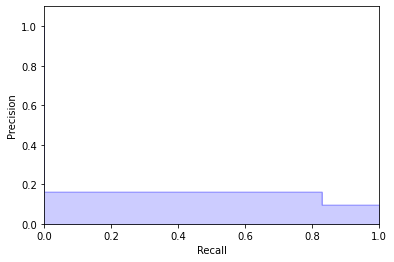

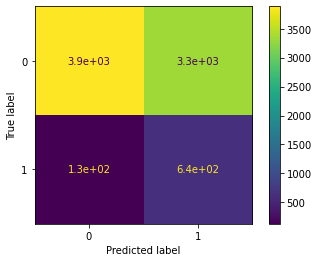

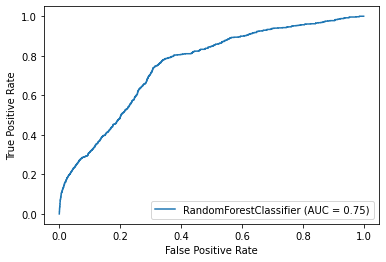

In [185]:
predictions = gridsearch_rf.best_estimator_.predict(prepared_validation_features)
report_results(gridsearch_rf.best_estimator_, prepared_validation_features, prepared_validation_labels, predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

Max oob 0.8934126876775328 at number of estimators 45


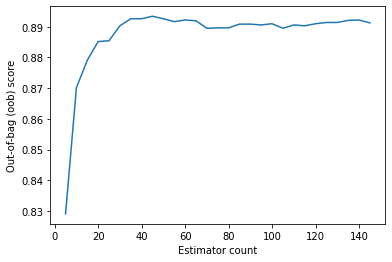

In [186]:
obb = []
estimator_count = list(range(5, 150, 5))

for i in estimator_count:
    random_forest = RandomForestClassifier(n_estimators=i, criterion='entropy',
                                           random_state=42, oob_score=True,
                                           max_depth=25, min_samples_leaf=80,
                                           min_samples_split=3)
    random_forest.fit(features, labels)
    obb.append(random_forest.oob_score_)

max_obb = max(obb)
optimal_estimator_count = estimator_count[np.argmax(obb)]
print('Max oob {} at number of estimators {}'.format(max_obb, optimal_estimator_count))
plt.plot(estimator_count, obb)
plt.xlabel('Estimator count')
plt.ylabel('Out-of-bag (oob) score')
plt.show();

In [188]:
rf = RandomForestClassifier(n_estimators=optimal_estimator_count, criterion='entropy',
                                        random_state=42, oob_score=True,
                                        max_depth=25, min_samples_leaf=80,
                                        min_samples_split=3)

y_prepared = le.fit_transform(df_full['y'])
X_prepared = full_pipeline.fit_transform(df_full.drop('y', axis=1), y_prepared)
rf.fit(X_prepared, y_prepared)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=80, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=45,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

Number of non-subscribed: 7235
Number of subscribed: 765
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7235
           1       0.43      0.15      0.22       765

    accuracy                           0.90      8000
   macro avg       0.67      0.56      0.58      8000
weighted avg       0.87      0.90      0.88      8000

AUC score: 0.6630087040575272


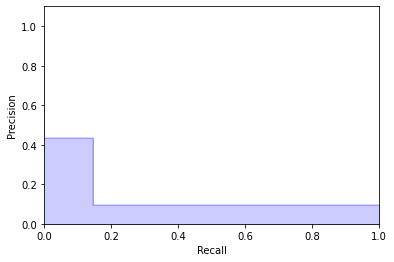

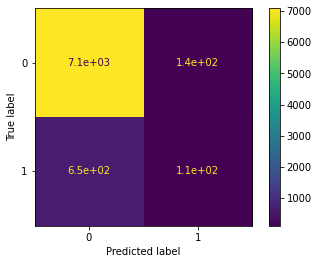

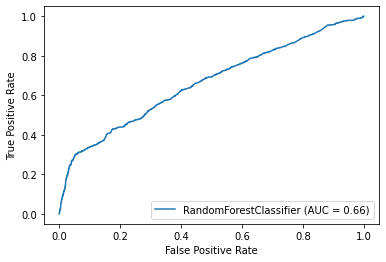

In [189]:
predictions = rf.predict(prepared_validation_features)
report_results(rf, prepared_validation_features, prepared_validation_labels, predictions)

### Final evaluation on test set
